## Import

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
#large radius => brighter around center. Too small radius would cut the image
def create_grad_img(center, radius, thickness = 2, speed=1):
    grad_img = np.zeros((512, 512, 3), dtype='uint8')
    for i in range(1,radius):
        color = 255-int(speed*i/radius*255)
        grad_img = cv2.circle(grad_img, center, i, (color, color, color), thickness)
    return grad_img

def get_rotate_matrix(h, w, alpha, beta, gamma, dx, dy, dz, f):
    """
    Source: http://jepsonsblog.blogspot.com/2012/11/rotation-in-3d-using-opencvs.html
    90 degrees being the "normal" position.
    
    alpha: the rotation around the x axis
    beta: the rotation around the y axis
    gamma: the rotation around the z axis (basically a 2D rotation)
    dx: translation along the x axis
    dy: translation along the y axis
    dz: translation along the z axis (distance to the image)
    f: focal distance (distance between camera and image, a smaller number exaggerates the effect)
    """

    alpha = (alpha - 90.)*np.pi/180.
    beta = (beta - 90.)*np.pi/180.
    gamma = (gamma - 90.)*np.pi/180.
    # Projection 2D -> 3D matrix
    A1 = np.array([[1, 0, -w/2],
          [0, 1, -h/2],
          [0, 0,    0],
          [0, 0,    1]])
    # Rotation matrices around the X, Y, and Z axis
    RX = np.array([[1,          0,           0, 0],
          [0, np.cos(alpha), -np.sin(alpha), 0],
          [0, np.sin(alpha),  np.cos(alpha), 0],
          [0,          0,           0, 1]])
    RY = np.array([[np.cos(beta), 0, -np.sin(beta), 0],
          [0, 1,          0, 0],
          [np.sin(beta), 0,  np.cos(beta), 0],
          [0, 0,          0, 1]])
    RZ = np.array([[np.cos(gamma), -np.sin(gamma), 0, 0],
          [np.sin(gamma),  np.cos(gamma), 0, 0],
          [0,          0,           1, 0],
          [0,          0,           0, 1]])
    # Composed rotation matrix with (RX, RY, RZ)
    R = np.matmul(np.matmul(RX, RY), RZ)
    # Translation matrix
    T = np.array([[1, 0, 0, dx],
         [0, 1, 0, dy],
         [0, 0, 1, dz],
         [0, 0, 0, 1]])
    # 3D -> 2D matrix
    A2 = np.array([[f, 0, w/2, 0],
          [0, f, h/2, 0],
          [0, 0,   1, 0]])
    # Final transformation matrix
    return np.matmul(A2, np.matmul(T, np.matmul(R, A1)))

def first_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def last_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

def get_mask_bbox(img):
    sum_y = np.sum(img, axis=0)
    sum_x = np.sum(img, axis=1)
    l = first_nonzero(sum_y, 0)[0]
    r = last_nonzero(sum_y, 0)[0]
    t = first_nonzero(sum_x, 0)[0]
    b = last_nonzero(sum_x, 0)[0]
    return (l, r, t, b)

def mask_to_shadow(mask, rot_rd_low, rot_rd_high, trans_rd_low, trans_rd_high):
    # Rotate image
    h, w = mask.shape[0], mask.shape[1]
    rot_rd = np.random.randint(low = rot_rd_low, high = rot_rd_high)
    rotate_matrix = get_rotate_matrix(h, w, alpha=90+rot_rd, beta=90, gamma=90, dx=0, dy=0, dz=200, f=200)
    rotated = cv2.warpPerspective(mask, rotate_matrix, (h, w), cv2.INTER_LANCZOS4)
    
    # Translate image so the shadow touch the legs
    # Translate after rotate x-axis or it won't be correct
    l, r, t, b = get_mask_bbox(mask)
    new_l, new_r, new_t, new_b = get_mask_bbox(rotated)
    # matching the x-axis center of 2 bboxes
    dx=int((r-l)-(new_r-new_l))//2+np.random.randint(low=trans_rd_low, high=trans_rd_high)
    # matching the bottom of 2 bboxes
    dy=int(b-new_b)+np.random.randint(low=trans_rd_low, high=trans_rd_high)
    trans_matrix = get_rotate_matrix(h, w, alpha=90, beta=90, gamma=90, dx=dx, dy=dy, dz=200, f=200)
    warped = cv2.warpPerspective(rotated, trans_matrix, (h, w), cv2.INTER_LANCZOS4)
    return warped

def create_gradient_shadow_alpha_mask(shadow_mask, rd_low, rd_high):
    """
    The rd_low and high determine the gradient shade of the shadow.
    Increase the value to have fader shade
    """
    final_l, final_r, final_t, final_b = get_mask_bbox(warped)
    rd = np.random.randint(low = rd_low, high = rd_high)
    grad_img = create_grad_img(((final_l+final_r)//2,final_b+rd),256) # Hard-code here

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = grad_img.astype(float)/255
    return alpha

In [29]:
img = cv2.imread('./svm_samples/images/4.png')
c_src = np.array([
    [0.0, 0.0],
    [1., 0],
    [1, 1],
    [0, 1],
    [0.3, 0.3],
    [0.7, 0.7],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])

c_dst = np.array([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])

warped = warp_image_cv(img, c_src, c_dst)
# warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

NameError: name 'warp_image_cv' is not defined

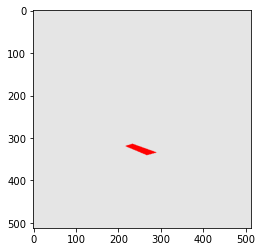

In [30]:
shadow_mask = np.zeros((512,512,3))+(0.9,0.9,0.9)
pts = np.array([[217,319],[233,314],[289,334],[267,340]], np.int32)
# pts = pts.reshape((2,0))
# pts = pts.reshape((-1,1,2))
cv2.fillPoly(shadow_mask,[pts],color=(1,0,0))
plt.imshow(shadow_mask, origin='upper')
# plt.imshow(img[...,::-1], origin='upper')

In [15]:
shadow_mask.shape

(512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


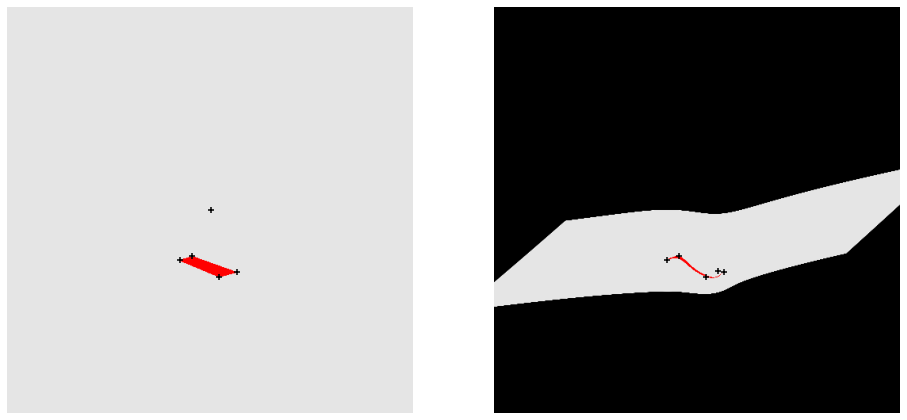

In [142]:
c_src = np.array([
    [0.5, 0.5],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])

c_dst = np.array([
    [0.55, 0.65],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])
warped = warp_image_cv(shadow_mask[...,::-1], c_src, c_dst)
# warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(shadow_mask[...,::-1], warped)

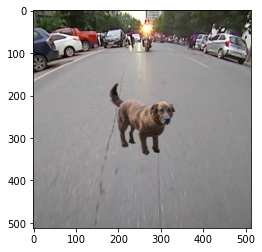

In [45]:
img = cv2.imread('./svm_samples/images/4.png')
mask = cv2.imread('./svm_samples/foreground_object_mask/4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
background=cv2.subtract(img,mask)
cut_obj=cv2.subtract(img,background)

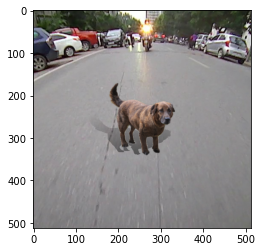

In [145]:
shadow_mask = mask_to_shadow(mask, rot_rd_low=45, rot_rd_high=80, trans_rd_low=-3, trans_rd_high=3)
alpha = create_gradient_shadow_alpha_mask(shadow_mask, rd_low=150, rd_high=200)
revert_shadow_mask=cv2.subtract(img,shadow_mask)

# Convert uint8 to float
# shadow_foreground = shadow_grad_blur.astype(float)
revert_shadow_mask_f = revert_shadow_mask.astype(float)
img_f = img.astype(float)

# Multiply the foreground with the alpha matte
foreground_shadow = cv2.multiply(alpha, revert_shadow_mask_f)

# Multiply the background with ( 1 - alpha )
background_img = cv2.multiply(1.0 - alpha, img_f)

# Add the masked foreground and background.
shadow_on_top = cv2.add(foreground_shadow, background_img)
shadow_on_top = shadow_on_top.astype('uint8')

final_background=cv2.subtract(shadow_on_top,mask)
final_img = cut_obj+final_background
plt.imshow(final_img[...,::-1])

## Notes:
- Control shadow rotation
- Extra pixels of the outline mask => ??? cut shadow mask, not object?